# RecentCandles Dashboard
 
Contract info can be found here: https://pennies.interactivebrokers.com/cstools/contract_info/v3.10/index.php 

## Connect to IB

In [1]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper  
from ibapi.contract import Contract

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mpl_dates

import talib

from datetime import datetime, timezone
from zoneinfo import ZoneInfo

import threading
import time

class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)

    def tickPrice(self, reqId, tickType, price, attrib):
        if tickType == 2 and reqId == 1:
            print(tickType, ': The current ask price is: ', price)
    
    def historicalData(self, reqId, bar):        
        collectData(reqId, bar)

def run_loop():
    ib.run()

ib = IBapi()
ib.connect('host.docker.internal', 7496, 666)

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()
time.sleep(1)


ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:uscrypto
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds.nj
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefeu


## Setup data for Dashboard


In [2]:
class ContractWrapper:

    def __init__(self, contract, contractName = None):
        self.contract = contract
        self.data = dict() # data keyed by ReqId
        if contractName is not None:
            self.contractName = contractName
        else:
            self.contractName = (contract.symbol, contract.symbol+'_'+contract.currency)[contract.exchange == 'IDEALPRO']

class Contracts:

    def __init__(self):
        self.contracts = list()
        
    def info(self):
        return f"list of contracts: {self.contracts} "

    def add(self, contractWrapper: ContractWrapper):
        self.contracts.append(contractWrapper)

# Define Contracts
contractsList = Contracts()
def addContract(symbol, secType, exchange, currency, contractMonth = None, contractName = None):
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    if contractMonth is not None:
        contract.lastTradeDateOrContractMonth = contractMonth
    wrapper = ContractWrapper(contract, contractName)
    contractsList.add(wrapper)

def determine_date_format(date_str):
    #20230407
    formats = ['%Y%m%d', '%Y%m%d %H:%M:%S']
    for fmt in formats:
        try:
            datetime.strptime(date_str, fmt)
            return fmt
        except ValueError:
            pass
    return None

# Define a callback for IB Historical data
def collectData(reqId, bar): 
    for contractItem in contractsList.contracts:
        if reqId in contractItem.data.keys():
            dateFormat = determine_date_format(bar.date)
            #print(f'Date format {dateFormat}')
            seconds = None
            if dateFormat:
                date = datetime.strptime(bar.date, dateFormat)
                seconds = (date - datetime(1970, 1, 1)).total_seconds()
            else:
                seconds = bar.date
            thisCandle = [seconds, bar.open, bar.high, bar.low, bar.close]
            contractItem.data[reqId].append(thisCandle)               

# Find reversals for a specific candleSize dataFrame, e.g. EURUSD 4H candles for  
def find_reversal_points(df): 
    reversal_points = []
    down_reversal_points = []
    # Loop through the DataFrame rows
    minus1Candle = None
    minus1CandleIndex = None
    minus2Candle = None
    minus2CandleIndex = None
    #print(f"No of rows in dataFrame: {len(df)}")
    for index, thisCandle in df.iterrows():
        
        # Check for 2B reversal to the upside
        if minus1Candle is not None and minus2Candle is not None \
            and minus1Candle['Low'] < minus2Candle['Low'] \
            and minus1Candle['High'] < minus2Candle['High'] \
            and thisCandle['Close'] > minus2Candle['High']:
            #print(f"Register 2b reversal: close {thisCandle['Close']} > -2 high {minus2Candle['High']}")
            reversal_points.append(thisCandle['Low'])
        else:
            reversal_points.append(np.nan)
        
        # Check for 2B reversal to the downside
        if minus1Candle is not None and minus2Candle is not None \
            and minus1Candle['Low'] > minus2Candle['Low'] \
            and minus1Candle['High'] > minus2Candle['High'] \
            and thisCandle['Close'] < minus2Candle['Low']:
            down_reversal_points.append(thisCandle['High'])
        else:
            down_reversal_points.append(np.nan)
                
        # Update the previous candles variables for the next iteration
        minus2Candle = minus1Candle
        minus2CandleIndex = minus1CandleIndex

        minus1Candle = thisCandle
        minus1CandleIndex = index

    return reversal_points, down_reversal_points


# Sanitise data ndarray to DataFrame
def to_dataframe(data):
    if not data:
        return None
    
    df = pd.DataFrame(data, columns=['DateTime', 'Open', 'High', 'Low', 'Close'])
    df['DateTime'] = pd.to_datetime(df['DateTime'],unit='s', infer_datetime_format=True)
    df = df.set_index('DateTime')
    
    df['ema10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['ema30'] = df['Close'].ewm(span=30, adjust=False).mean()

    return df

# Sanitise data ndarray to DataFrame, return only last 6 candles
def to_dataframe_last6candles(data):
    if not data:
        return None
    df = to_dataframe(data)
    df = df.tail(6)
    return df
"""
def add_2b_reversal_date(df):
    # Define your rules to identify 2B reversal
    if len(candles) < 3:
        return False

    # Check for a bullish 2B reversal
    if candles[-3]['trend'] == 'down' and \
       candles[-2]['low'] < candles[-3]['low'] and \
       candles[-1]['high'] > candles[-2]['high']:
        return True

    # Check for a bearish 2B reversal
    if candles[-3]['trend'] == 'up' and \
       candles[-2]['high'] > candles[-3]['high'] and \
       candles[-1]['low'] < candles[-2]['low']:
        return True

    return False
"""

# Initialise Contracts for the Dashboard    
addContract('EUR', 'CASH', 'IDEALPRO', 'USD', contractName='EUR.USD')
addContract('EUR', 'CASH', 'IDEALPRO', 'ZAR', contractName='EUR.ZAR')
addContract('ES', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='ES Futures')
addContract('MNQ', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='E-Mini NQ 100')
addContract('YM', 'FUT', 'CBOT', 'USD', contractMonth='20230616', contractName='Dow Jones (YM)')
#addContract('BTC', 'CRYPTO', 'PAXOS', 'USD')
addContract('BRR', 'FUT', 'CME', 'USD', contractMonth='20230526', contractName='BTC Futures')
addContract('XAUUSD', 'CMDTY', 'SMART', 'USD', contractName='Gold')
addContract('XAGUSD', 'CMDTY', 'SMART', 'USD', contractName='Silver')

#print(contractsList.contracts)

## Request IB historical data

In [3]:
timeSpan = '6 W'
candleSizes = ['1 week','1 day','4 hours','1 hour']
rId = 0
for contract in contractsList.contracts:
    print(f"Requesting historical data for {contract.contract.symbol}_{contract.contract.currency} ...")
    for candleSize in candleSizes:
        rId = rId + 1
        #print(f"  ReqID {rId} - timeSpan:'{timeSpan}' candleSize:'{candleSize}'")
        contract.data[rId] = list()
        ib.reqHistoricalData(rId, contract.contract, '', timeSpan, candleSize, 'MIDPOINT', 0, 2, False, [])
        #print(f"  ReqID {rId} Done.")
        time.sleep(0.1)
    print(f"Done for {contract.contract.symbol}_{contract.contract.currency} ...")
    print(f"------------------------------------------------------------------------------------------")

#wait for all data to come in
time.sleep(3)

Requesting historical data for EUR_USD ...
Done for EUR_USD ...
------------------------------------------------------------------------------------------
Requesting historical data for EUR_ZAR ...
Done for EUR_ZAR ...
------------------------------------------------------------------------------------------
Requesting historical data for ES_USD ...
Done for ES_USD ...
------------------------------------------------------------------------------------------
Requesting historical data for MNQ_USD ...
Done for MNQ_USD ...
------------------------------------------------------------------------------------------
Requesting historical data for YM_USD ...
Done for YM_USD ...
------------------------------------------------------------------------------------------
Requesting historical data for BRR_USD ...
Done for BRR_USD ...
------------------------------------------------------------------------------------------
Requesting historical data for XAUUSD_USD ...
Done for XAUUSD_USD ...
----

## Plot 

## Plot in Grid

Executed at 2023-05-18 14:55:19.271998+02:00


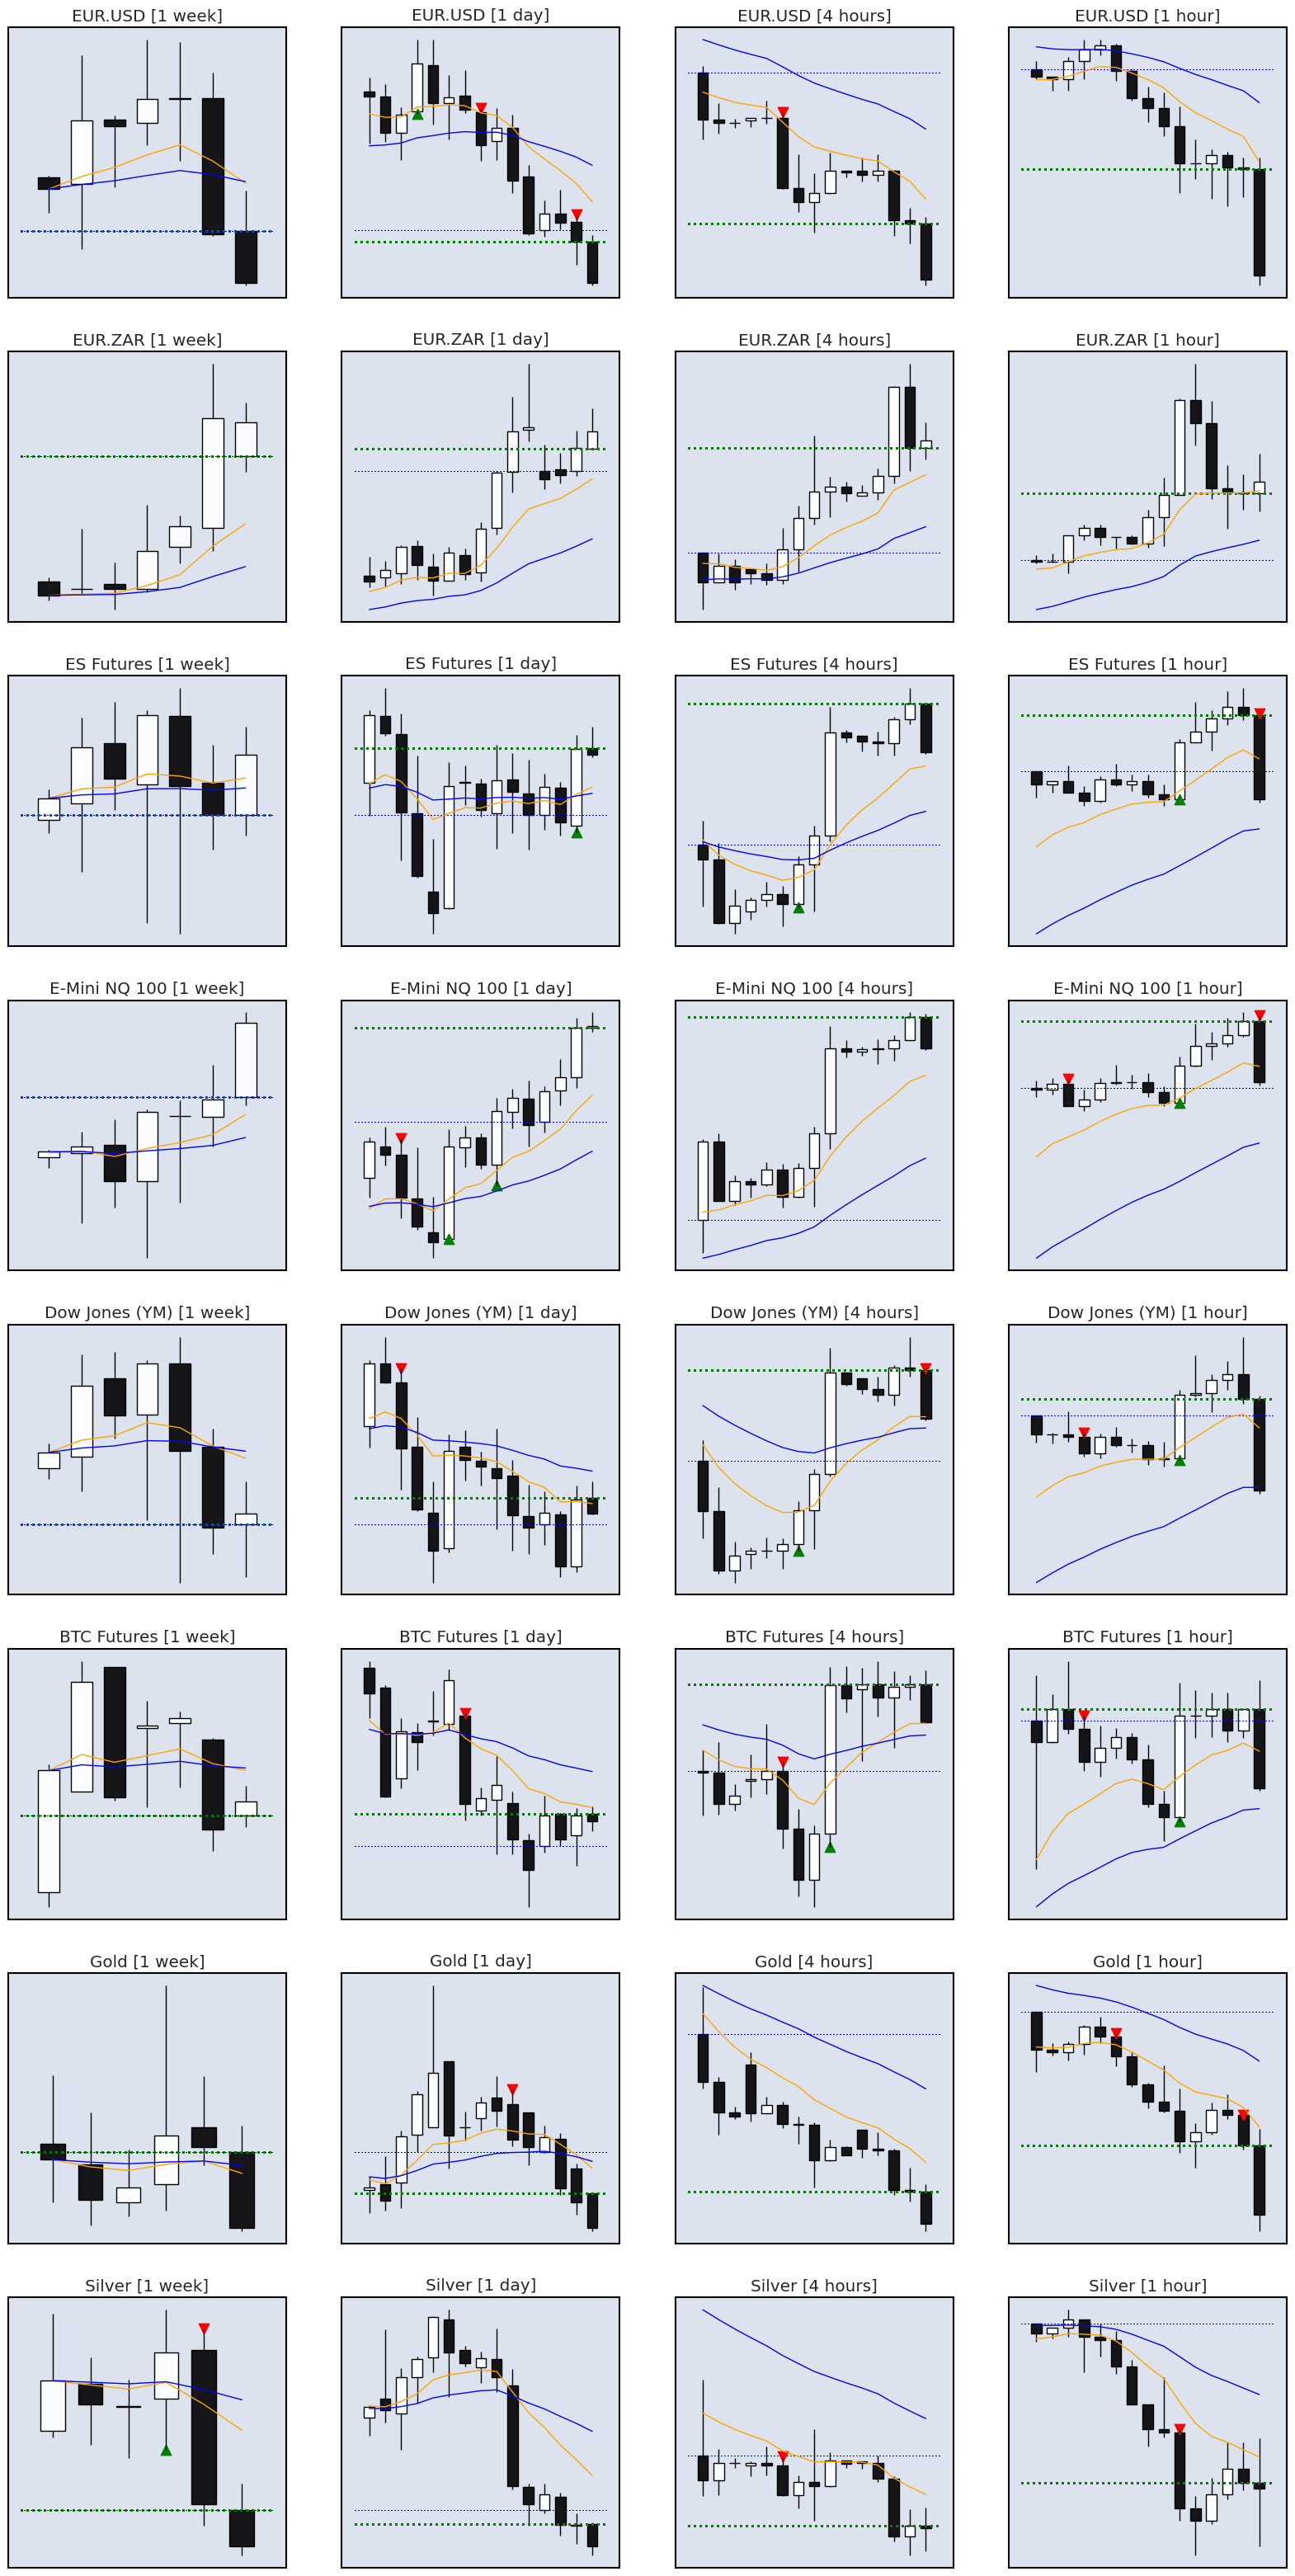

In [7]:
rows = len(contractsList.contracts)
columns = 4
rowHeight = 5
figWidth = 18
figHeight = rowHeight * rows
noOfCandles = 15
fig = mpf.figure(figsize=(figWidth,figHeight))

def get_contract_plus_candle_size(reqId, columns, contractName):
    diff = reqId%columns
    title = contractName
    match diff:
        case 1: # Weekly
            title = f"{c.contractName} [{candleSizes[0]}]"
        case 2: # Daily
            title = f"{c.contractName} [{candleSizes[1]}]"
        case 3: # H4
            title = f"{c.contractName} [{candleSizes[2]}]"
        case 0: # H1
            #print(f"{c.contractName} [{candleSizes[3]}] monthly open price: {current_month_open_price}")
            title = f"{c.contractName} [{candleSizes[3]}]"    
    return title

# For each contract
for c in contractsList.contracts:    
    # For each requested candleSize data array. key=reqId, value=contractNDArray
    for reqId,contractDataArray in c.data.items():    
        if contractDataArray:
            title = get_contract_plus_candle_size(reqId, columns, c.contractName)
            #contractPriceDataDF = to_dataframe_last6candles(contractDataArray)
            contractPriceDataDF = to_dataframe(contractDataArray)
            
            #print(f'{title}')
            #print('ARRAY')
            #print(f'{contractDataArray}')
            #print('DATAFRAME')
            #print(f'{contractPriceDataDF}')
            
            reversalPoints, downReversalPoints = find_reversal_points(contractPriceDataDF)
            
            
            contractPriceDataDF = contractPriceDataDF.tail(noOfCandles)
            negNoOfCandles = -noOfCandles
            reversalPoints = reversalPoints[negNoOfCandles:]
            downReversalPoints = downReversalPoints[negNoOfCandles:]
            
            monthly_open = contractPriceDataDF['Open'].resample('M').last()
            monthly_open_price = monthly_open.iloc[-1]
            
            weekly_open = contractPriceDataDF['Open'].resample('W').first()
            weekly_open_price = weekly_open.iloc[-1]
            
            ax1 = fig.add_subplot(rows, columns, reqId)
            ax1.axes.xaxis.set_visible(False)
            ax1.axes.yaxis.set_visible(False)
            #additionalPlot = mpf.make_addplot(to_dataframe(reversal_points), scatter=True, markersize=100, marker='^', color='red')

            hlines=dict( hlines=(monthly_open_price,weekly_open_price),colors=['g','b'],linestyle='dotted',linewidths=(2,1) )
            #print(f'M open: {monthly_open_price}, W open: {weekly_open_price}')
            #print('-------------------------')
            noReversals = all(np.isnan(item) for item in reversalPoints)
            noDownReversals = all(np.isnan(item) for item in downReversalPoints)
            #print(f'reversals {len(reversalPoints)}')
            #print(f'noreversals {noReversals}')
            #print(f'downReversals {len(downReversalPoints)}')
            #print(f'noDownReversals {noDownReversals}')

            
            aps=[]
            
            if not noDownReversals:
                aps.append(mpf.make_addplot(downReversalPoints, ax=ax1, type='scatter', marker='v', markersize=80, color='red'))
            if not noReversals:
                aps.append(mpf.make_addplot(reversalPoints, ax=ax1, type='scatter', marker='^', markersize=80, color='green'))
            
            #ema_10 = talib.EMA(contractPriceDataDF['Close'], timeperiod=10)
            #print(type(ema_10))
            aps.append(mpf.make_addplot(contractPriceDataDF['ema10'], ax=ax1, color='orange', width=1))
            aps.append(mpf.make_addplot(contractPriceDataDF['ema30'], ax=ax1, color='blue', width=1))
            
            mpf.plot(contractPriceDataDF, ax=ax1, addplot=aps, hlines=hlines, type='candle', axtitle=title)


print(f"Executed at {datetime.now(ZoneInfo('Europe/Amsterdam'))}")


# Disconnect from IB

In [5]:
ib.disconnect()